In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
from scipy.stats import norm

import statsmodels.api as sm

import hashlib
%matplotlib inline

sns.set(style="dark")
plt.style.use("ggplot")

In [2]:
pre_life = pd.read_csv('~/Downloads/Life Expectancy Data.csv') #2000 - 2015
life = pre_life.dropna()
pre_happy = pd.read_csv("~/Downloads/World Happiness Report.csv") #between 2005 and 2022
happy = pre_happy.dropna()

## Getting P-Values from OLS Estimation

In [3]:
merged = life.merge(happy, how='inner', left_on='Country', right_on='Country Name')

In [4]:
# columns that we will be looking at for association with life_expectancy
X = ['Log GDP Per Capita', 'Social Support', 'Freedom To Make Life Choices', 'Generosity', 'Perceptions Of Corruption', 'Confidence In National Government']

In [5]:
def fit_OLS_model(df, target_variable, explanatory_variables, intercept = False):
    """
    Fits an OLS model from data.
    
    Inputs:
        df: pandas DataFrame
        target_variable: string, name of the target variable
        explanatory_variables: list of strings, names of the explanatory variables
        intercept: bool, if True add intercept term
    Outputs:
        fitted_model: model containing OLS regression results
    """
    
    target = df[target_variable]
    inputs = df[explanatory_variables]
    if intercept:
        inputs = sm.add_constant(inputs)
    
    fitted_model = sm.OLS(target, inputs).fit()
    return(fitted_model)

def mean_squared_error(true_vals, predicted_vals):
    """
    Return the mean squared error
    
    Inputs:
        true_vals: array of true labels
        predicted_vals: array labels predicted from the data
    Output:
        float, mean squared error of the predicted values
    """
    return np.mean((true_vals - predicted_vals) ** 2)

In [6]:
linear_model = fit_OLS_model(merged, 'Life expectancy ', ['Social Support', 'Freedom To Make Life Choices', 'Generosity', 'Perceptions Of Corruption', 'Confidence In National Government', 'Log GDP Per Capita'])
pvalues = linear_model.pvalues.values

In [38]:
linear_model.ess

83541402.99921514

In [7]:
pvalues

array([5.34315263e-23, 6.07507730e-17, 3.52609983e-44, 1.15581942e-08,
       2.52247751e-38, 0.00000000e+00])

## Benjamini Yekutieli Correction

In [8]:
def benjamini_yekutieli(p_values, alpha):
    """
    Returns decisions on p-values using Benjamini-Hochberg.
    
    Inputs:
        p_values: array of p-values
        alpha: desired FDR (FDR = E[# false positives / # positives])
    
    Returns:
        decisions: binary array of same length as p-values, where `decisions[i]` is 1
        if `p_values[i]` is deemed significant, and 0 otherwise
    """
    n = len(p_values)
    c = np.sum([1/i for i in np.arange(1, n)]) #is n the number of samples, or the num of p-values
    assorted_p = sorted(p_values)
    line = sorted([k*(alpha)/(n * c) for k in range(1, len(assorted_p) + 1)])
    
    chosen_p = 0 
    for i in range(len(assorted_p)):
        if line[i] > assorted_p[i]:
            chosen_p = i
    
    decisions = np.array(assorted_p[chosen_p] >= p_values)
    return decisions

In [9]:
decision_by = benjamini_yekutieli(pvalues, 0.05)
decision_by

array([ True,  True,  True,  True,  True,  True])

In [10]:
p_and_decisions = pd.DataFrame(data={'pvalue': pvalues, 'is_alternative': decision_by.astype(int)})

Text(0.5, 1.0, 'P-values and decisions using p-value threshold 0.05, with ground truth labels')

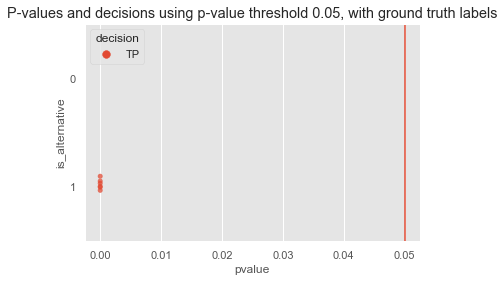

In [11]:
threshold = 0.05
p_and_decisions['decision'] = 'TP'
p_and_decisions.loc[(p_and_decisions['pvalue'] > threshold) & (~p_and_decisions['is_alternative']), 'decision'] = 'TN'
p_and_decisions.loc[(p_and_decisions['pvalue'] < threshold) & (~p_and_decisions['is_alternative']), 'decision'] = 'FP'
p_and_decisions.loc[(p_and_decisions['pvalue'] > threshold) & (p_and_decisions['is_alternative']), 'decision'] = 'FN'
sns.stripplot(
    data=p_and_decisions, x='pvalue', y='is_alternative', 
    alpha = 0.75, order = [0, 1], hue='decision', orient = "h",
)
plt.axvline(threshold)
plt.title('P-values and decisions using p-value threshold {}, with ground truth labels'.format(threshold))

# Bonferroni Correction

In [12]:
def bonferroni(p_values, alpha_total):
    """
    Returns decisions on p-values using the Bonferroni correction.
    
    Inputs:
        p_values: array of p-values
        alpha_total: desired family-wise error rate (FWER = P(at least one false discovery))
    
    Returns:
        decisions: binary array of same length as p-values, where `decisions[i]` is 1
        if `p_values[i]` is deemed significant, and 0 otherwise
    """
    decisions = [(alpha_total)/len(p_values) >= p for p in p_values]
    return np.array(decisions)

In [13]:
decision_b = bonferroni(pvalues, 0.05)
decision_b

array([ True,  True,  True,  True,  True,  True])

In [14]:
p_and_decisions = pd.DataFrame(data={'pvalue': pvalues, 'is_alternative': decision_b.astype(int)})

Text(0.5, 1.0, 'P-values and decisions using p-value threshold 0.05, with ground truth labels')

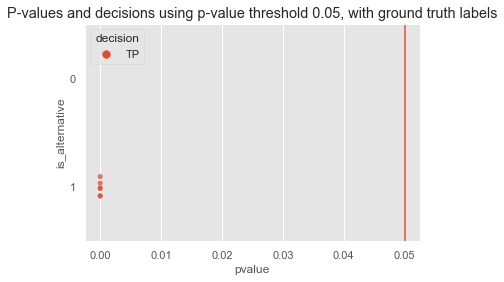

In [15]:
threshold = 0.05
p_and_decisions['decision'] = 'TP'
p_and_decisions.loc[(p_and_decisions['pvalue'] > threshold) & (~p_and_decisions['is_alternative']), 'decision'] = 'TN'
p_and_decisions.loc[(p_and_decisions['pvalue'] < threshold) & (~p_and_decisions['is_alternative']), 'decision'] = 'FP'
p_and_decisions.loc[(p_and_decisions['pvalue'] > threshold) & (p_and_decisions['is_alternative']), 'decision'] = 'FN'
sns.stripplot(
    data=p_and_decisions, x='pvalue', y='is_alternative', 
    alpha = 0.75, order = [0, 1], hue='decision', orient = "h",
)
plt.axvline(threshold)
plt.title('P-values and decisions using p-value threshold {}, with ground truth labels'.format(threshold))

## Power

Hypothesis we will calculate the power for: Is there an association between Freedom To Make Life Choices and life expectancy? 

In [44]:
effect_size = np.mean(merged['Freedom To Make Life Choices'])-np.mean(merged['Life expectancy '])/np.std(merged['Freedom To Make Life Choices'])
effect_size

-523.6334247047739

In [26]:
life.columns

Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')

In [45]:
from statsmodels.stats.power import TTestPower

power = TTestPower()
test = power.power(nobs=len(merged), effect_size=effect_size, alpha = .05)
print('Power: {:.5f}'.format(test))

Power: 1.00000


In [46]:
linear_model.ess

83541402.99921514

In [24]:
# There is a 100% chance of rejecting the null under the alternative

In [ ]:
https://resources.nu.edu/statsresources/eta 